In [ ]:
# Name: David Le
# Student Number: 1327116
# 6147 Final Project

In [10]:
# import the libraries used

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
from PIL import Image
from itertools import product
import torch.optim as optim

df = pd.read_csv("fer2013.csv")
df["pixelPicture"] = [[int(y) for y in x.split()] for x in df["pixels"]]
df.head()

,emotion,pixels,Usage,pixelPicture
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


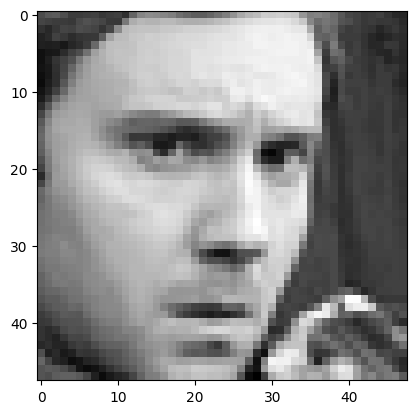

In [11]:
# get sample pixel image of what an emotion could look like

pic = np.array(df["pixelPicture"][0])
picA = pic.reshape(48, 48)
plt.imshow(picA, interpolation = "nearest", cmap = "gray")
plt.show()

In [26]:
# Will be used to plot metrics that was evaluated

def plot_loss(train_loss):
  plt.figure(figsize = (12, 5))

  # Loss
  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label = "Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.tight_layout()
  plt.show()

In [13]:
# apply transformations and preprocessing

class imageDataset(Dataset):
    def __init__(self, df, transform = None):
      self.data = df[df["pixels"].apply(lambda x: len(x.split()) == 2304 )].reset_index(drop = True) # remove invalid pixel lengths
      self.transform = transform

    def __len__(self):
      return len(self.data)

    def __getitem__(self, i):
      emotions = int(self.data.iloc[i]["emotion"])
      pixels = list(map(int, self.data.iloc[i]["pixels"].split()))
      image = np.asarray(pixels).reshape(48, 48).astype(np.uint8)
      image = Image.fromarray(image)

      if self.transform:
        image = self.transform(image)

      return image, emotions

In [14]:
# functions to train and validate model

def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [15]:
train_df = df[df["Usage"] == "Training"]
test_df = df[df["Usage"] == "PrivateTest"]
val_df = df[df["Usage"] == "PublicTest"]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = imageDataset(train_df, transform = transform)
test_ds = imageDataset(test_df, transform = transform)
val_ds = imageDataset(val_df, transform = transform)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_ds, batch_size = 64)
val_loader = DataLoader(val_ds, batch_size = 64)

In [16]:
class emotionCNN(nn.Module):
  def __init__(self, dropout_rate = 0.05):
    super(emotionCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 12 * 12, 256)
    self.fc2 = nn.Linear(256, 7) # output is 7 emotion classifications
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x))) # (48, 48) down to (24, 24)
    x = self.pool(nn.functional.relu(self.conv2(x))) # (24, 24) down to (12, 12)
    x = x.view(-1, 64 * 12 * 12)
    x = self.dropout(nn.functional.relu(self.fc1(x)))
    x = self.fc2(x)
    return x

In [18]:
# finding best hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = [0.001, 0.005]
dropouts = [0.3, 0.5]
optimizers = ["adam", "sgd"]

hyperparams = list(product(lr, dropouts, optimizers))
best_accuracy = 0;
best_hyperparams = None

for lr, dropout, optimizer_name in hyperparams:
    model = emotionCNN(dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr) if optimizer_name == "adam" else optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

    for epoch in range(5):
        train(model, train_loader, criterion, optimizer, device)

    accur = validate(model, val_loader, device)
    if accur > best_accuracy:
        best_accuracy = accur
        best_hyperparams = (lr, dropout, optimizer_name)
print(f"Best Accuracy: {best_accuracy: .2f} with {best_hyperparams}")

Best Accuracy:  0.54 with (0.001, 0.5, 'adam')


In [19]:
# train our model

model = emotionCNN(best_hyperparams[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = best_hyperparams[0]) if best_hyperparams[2] == "adam" else optim.SGD(model.parameters(), lr = best_hyperparams[0], momentum = 0.9)
train_losses = []
val_accuracies = []

epochs = 20
for epoch in range(epochs):
  model.train()
  run_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    run_loss += loss.item()
  train_losses.append(run_loss / len(train_loader))
  print(f"Epoch #: {epoch + 1}, Loss: {run_loss / len(train_loader):.3f}")

Epoch #: 1, Loss: 1.627
Epoch #: 2, Loss: 1.413
Epoch #: 3, Loss: 1.303
Epoch #: 4, Loss: 1.211
Epoch #: 5, Loss: 1.137
Epoch #: 6, Loss: 1.061
Epoch #: 7, Loss: 0.986
Epoch #: 8, Loss: 0.911
Epoch #: 9, Loss: 0.839
Epoch #: 10, Loss: 0.775
Epoch #: 11, Loss: 0.711
Epoch #: 12, Loss: 0.657
Epoch #: 13, Loss: 0.603
Epoch #: 14, Loss: 0.559
Epoch #: 15, Loss: 0.521
Epoch #: 16, Loss: 0.486
Epoch #: 17, Loss: 0.448
Epoch #: 18, Loss: 0.429
Epoch #: 19, Loss: 0.413
Epoch #: 20, Loss: 0.382


In [27]:
# evaluate using validation dataset

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 54.81%


In [21]:
# use test data to see how well our model is trained

model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 56.37%


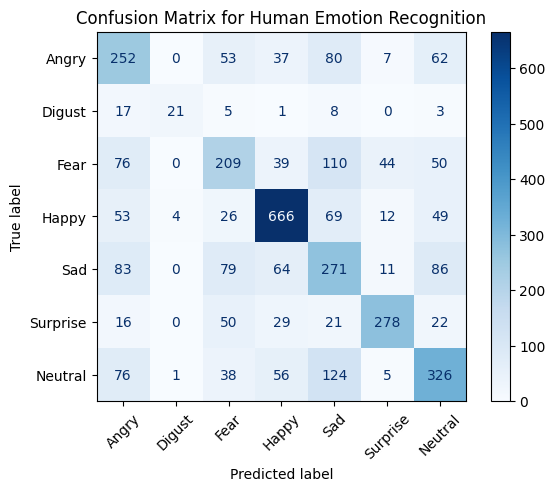

In [22]:
# show confusion matrix

classification_names = ["Angry", "Digust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
conf_matrix = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = classification_names)
display.plot(cmap = "Blues", xticks_rotation = 45)
plt.title("Confusion Matrix for Human Emotion Recognition")
plt.show()

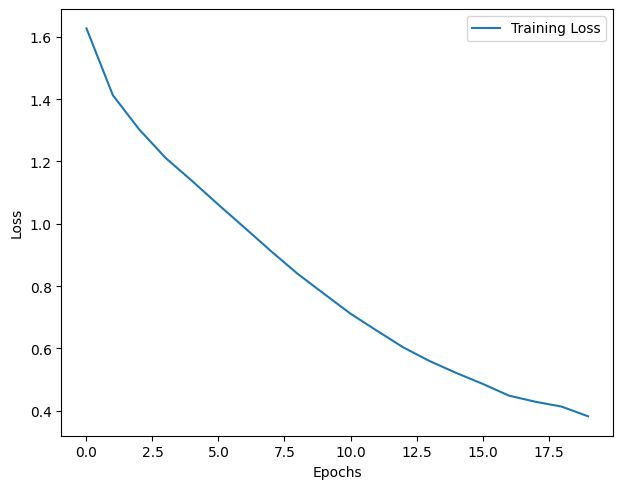

In [28]:
plot_loss(train_losses)

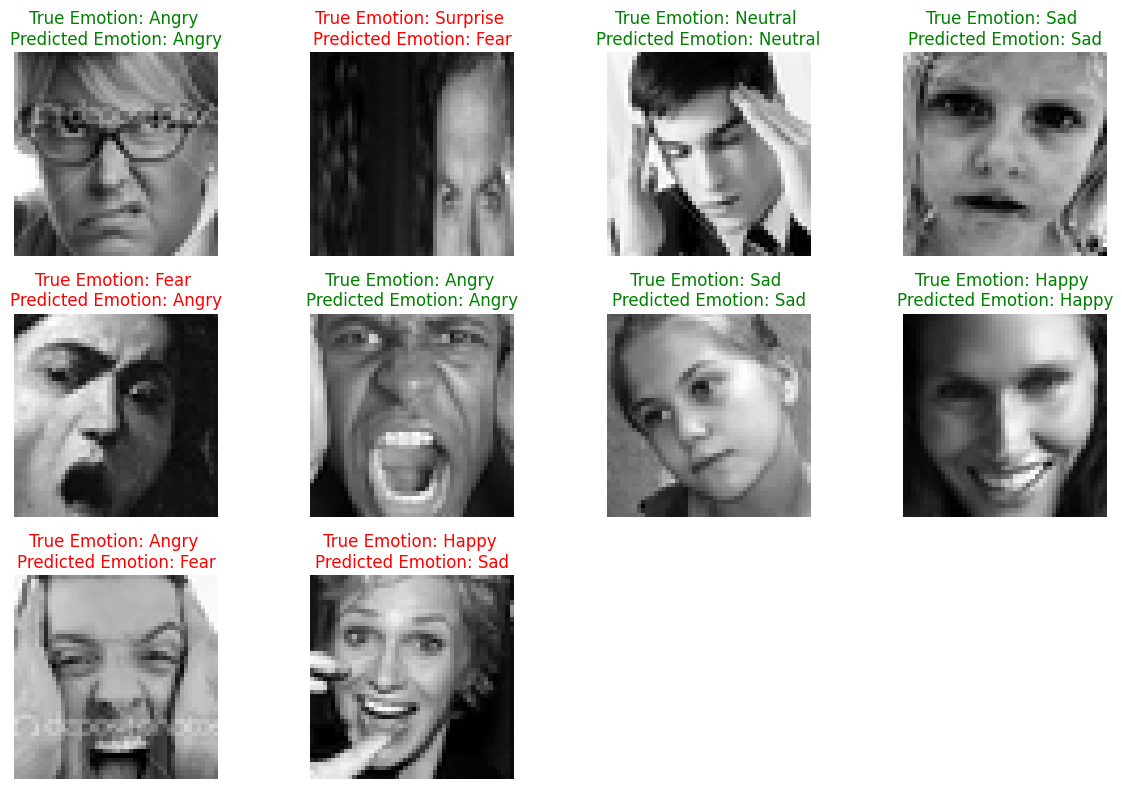

In [25]:
# show true vs predicted emotions

model.eval()
plt.figure(figsize = (12, 8))

for i in range(10):
    image, label = test_ds[i]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        _, predicted = torch.max(output, 1)

    image = image.squeeze().numpy()
    true_label = classification_names[label]
    pred_label = classification_names[predicted.item()]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(3, 4, i + 1)
    plt.imshow(image, cmap = "gray")
    plt.title(f"True Emotion: {true_label} \nPredicted Emotion: {pred_label}", color = color)
    plt.axis("off")

plt.tight_layout()
plt.show()